# 1-*INPUT*

La "source" des données à traiter est sous forme de fichiers .csv comportant la liste des
trades de bitcoin ayant eu lieu sur différents exchanges de Cryptomonnaies. 

La premiere partie du programme consistera à importer les **11 fichiers .csv** présents dans le même dossier que le notebook à travers les commandes :

`glob.glob(chemin des fichiers)` Cette fonction permet de lire tous les fichiers présents sous le chemin donné. 


`pd.read_csv("nom du fichier.csv")` Cette fonction permettera de définir chaque df à partir des données dans le csv file.

L'indexation par défaut se faisant de 0 à lignes-1, on utilisera la colonne 'timestamp' déjà incluse dans le fichier comme 
index avec les arguments de la commande pd.read_csv(`index_col='timestamp', parse_dates=True`)


Dans la même boucle, et par soucis d'optimisation une partie de la manipulation des données se fait en amont: 

Les produit des prix & valeurs seront calculés et stockés dans la colonne `[PV]`

Un resampling selon la fréquence pour calculer la somme horaire des PV et des volumes par la commande:
`df.resample(frequency).agg({'PV':['sum'],'amount':['sum']}`  avec frequency (5 min, 30 min ou 60 min) comme argument de ré-échantillonage et des fonctions aggrégés qui seront appliqués sur la colonne 'PV' et 'amount'

In [1]:
#import des librairies
import pandas as pd
import glob

In [2]:
#Requete d'input pour choisir la fréquence de calcul des métriques
frequency=input("Choisissez une fréquence de calcul: 5 min / 30 min / 60 min")
    
#définition du chemin d'accès
pattern = 'data/*.csv'
csv_files = glob.glob(pattern)

#définition de listes vides
dataframes = []
dfohlc = []
dfstd = []

#boucle qui combine: lecture, traitement et calcul des dataframes
for csv in csv_files:
    #Création d'un à partir fichier csv avec indexation selon la colonne 'timestamp'
    df = pd.read_csv(csv, index_col='timestamp', parse_dates=True)
    
    #Création d'une colonne PV=Price*Amount
    df['PV'] =df['price']*df['amount']
    
    #Création puis stockage d'un autre df avec ré-échantillonage pour avoir l'ohlc 
    df_ohlc=df['price'].resample(frequency).ohlc()
    dfohlc.append(df_ohlc)
    
    #Création puis stockage d'un autre df avec ré-échantillonage  pour avoir l'écart type 
    df_std=df['price'].resample(frequency).std()
    dfstd.append(pd.DataFrame(df_std))
    
    #Ré-échantillonage du df avec calcul des sommes des P*V et la somme des Amounts
    df=df.resample(frequency).agg({'PV':['sum'],'amount':['sum']})
    
    #Créaction d'une colonne Pvwap=Somme des P*V/Somme des Amounts
    df['Pvwap'] =df['PV', 'sum']/df['amount','sum']
    
    #Stockage de chaque df dans la liste des dataframes
    dataframes.append(df)

Choisissez une fréquence de calcul: 5 min / 30 min / 60 min60 min


# 2-*MANIPULATION*

In [3]:
dataframes[0].columns

MultiIndex([(    'PV', 'sum'),
            ('amount', 'sum'),
            ( 'Pvwap',    '')],
           )

Maintenant qu'une partie de la manipulation des données est déjà faite, il serait judicieux de 

tester la présence de valeurs manquantes et choisir quelle méthode appliquer pour les traiter.

En utilisant la fonction `.isna().sum()` qui affichera la somme des NaN par df

In [4]:
#Boucle de parcours de la liste dataframes pour test les valeurs manquantes
for x in dataframes:
    print(x.isna().sum())

PV      sum    0
amount  sum    0
Pvwap          1
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64
PV      sum    0
amount  sum    0
Pvwap          0
dtype: int64


Notons la présence de valeurs manquantes dans les dataframes sont dûes à l'absence de transactions à un intervalle de temps donné.

En assimilant le fait, que le prix n'ayant pas changé par rapport à l'intervalle précédent, on peut considérer la méthode `.fillna(method='ffill')` qui copiera les valeurs précédentes.

In [5]:
#application de la méthode forwardfill sur le dataframe contenant des NaN
for x in dataframes:
    x=x.fillna(method='ffill')


# 3-*CALCUL*

Le Volume weighted average price horaires du bitcoin se calculera avec cette formule:

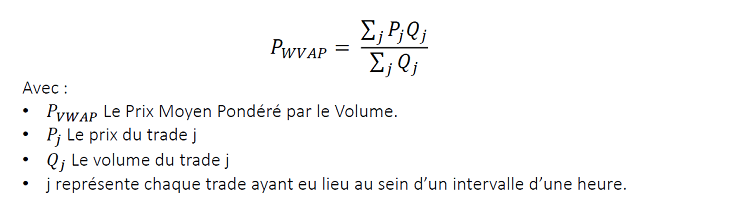

Etant donné qu'on a déjà calculé le Pvwap lors de la boucle initiale ainsi que les valeurs OHLC, il ne reste plus qu'à présenter le dataframe final.

### Le dataframe final présentera les Pvwap des 11 exchanges et l'index horaire.

Pour cela on utilisera la fonction `pd.concat` à qui on passera en argument une liste de compréhension `[x[('Pvwap', '')] for x in` 

`dataframes]` qui prendra que la colonne des Pvwap suivant l'axe des colonnes `axis=1`

Pour la bonne lecture des données, les Pvwap seront renommés avec le code de leur exchange avec`df.columns `.

Et finalement, une colonne `[global_Pvwap]` sera ajoutée qui présentera les Pvwap horaires globaux et qui sera égale à, pour 

une heure donnée, la somme de tous les P*V divisée par la somme de tous les amounts.


In [12]:
#Concatenation des 11 colonnes Pvwap dans un df 
dff=pd.concat([x[('Pvwap', '')] for x in dataframes],axis=1)

#Renommer chaque colonne par son exchange
dff.columns=['bfly_Pvwap','bfnx_Pvwap','bnus_Pvwap','btrx_Pvwap','cbse_Pvwap','gmni_Pvwap','itbi_Pvwap','krkn_Pvwap','lmax_Pvwap','okcn_Pvwap','stmp_Pvwap']

#Calcul du Pvwap global
for x in dataframes:
    dff['global_Pvwap']=x[('PV', 'sum')].sum()/x[('amount', 'sum')].sum()
    

# 4-*Dataframe final*

In [13]:
dff

,bfly_Pvwap,bfnx_Pvwap,bnus_Pvwap,btrx_Pvwap,cbse_Pvwap,gmni_Pvwap,itbi_Pvwap,krkn_Pvwap,lmax_Pvwap,okcn_Pvwap,stmp_Pvwap,global_Pvwap
timestamp,,,,,,,,,,,,
2021-02-24 00:00:00,48006.990396,47778.970482,47846.763010,47861.252787,47945.341624,47981.711507,47772.255562,47698.307100,47880.958914,47954.733900,47944.262770,49869.866475
2021-02-24 01:00:00,49607.923645,49441.592938,49196.187346,49343.265805,49317.201370,49458.079101,49509.699420,49179.026877,49250.834067,49422.816196,49220.299732,49869.866475
2021-02-24 02:00:00,50196.677303,50237.005036,50200.414314,50264.128120,50248.894775,50268.259968,50260.294897,50214.502350,50227.852912,50218.786802,50283.555918,49869.866475
2021-02-24 03:00:00,50948.000000,50608.443325,50523.291435,50528.684300,50498.142558,50494.398639,50533.802903,50537.044841,50458.462794,50435.243773,50472.637817,49869.866475
2021-02-24 04:00:00,50892.806229,50889.743300,50900.796481,50914.284328,50942.646520,50934.953286,51019.753640,50917.060833,50851.638004,51023.204299,50987.941708,49869.866475
2021-02-24 05:00:00,NaN,50344.152274,50383.987434,50537.358940,50513.989242,50528.602570,50416.281591,50421.092041,50473.959563,50399.457611,50440.124897,49869.866475
2021-02-24 06:00:00,49978.511632,49713.514206,50046.486487,50033.771901,49982.465002,49935.135891,49907.747367,49916.108053,50061.808328,49940.207735,49939.781897,49869.866475
2021-02-24 07:00:00,49680.100000,49899.138736,49861.581152,50032.963471,49959.624169,50034.858944,49944.963422,49994.271641,49996.280196,50030.400520,49974.235438,49869.866475
2021-02-24 08:00:00,50144.205464,50629.718533,50559.886413,50587.218865,50541.090694,50476.882959,50600.265267,50545.216768,50552.860398,50482.659430,50594.394449,49869.866475


#### 4-a Export du dataframe vers un fichier csv

In [ ]:
dff.to_csv(r'export_data\dataframe_final.csv')

# 5-*Calculs optionnels*

#### 5-a Standard deviation ou écart type

In [ ]:
#Concatenation des dataframes
dff_std=pd.concat([x for x in dfstd],axis=1)
dff_std.columns=['bfly_std','bfnx_std','bnus_std','btrx_std','cbse_std','gmni_std','itbi_std','krkn_std','lmax_std','okcn_std','stmp_std']

#Test des valeurs manquantes
dff_std.isna().sum()

L'écart type du premier exchange présente 3 valeurs manquantes, plusieurs méthodes existent pour traiter les valeurs manquantes des écarts types. 

L'utilisation de la moyenne quotidienne comme substitut des valeurs manquantes sera utilisée pour ne pas fausser la dispersion journalière des écarts types.

In [ ]:
#Remplacement des valeurs manquantes par la moyenne quotidienne
dff_std=dff_std.fillna(dff_std['bfly_std'].mean())

##### Dataframe avec écart type

In [ ]:
dff_std

In [ ]:
#Export du dataframe avec écart type

dff_std.to_csv(r'export_data\dff_std.csv')

#### 5-b OHLC (Open High Low Close values)

In [ ]:
#Concatenation des dataframes stockés dans la liste dfohlc
dff_ohlc=pd.concat([x for x in dfohlc],axis=1)

In [ ]:
#Test des valeurs manquantes
dff_ohlc.isna().sum()

Les valeurs manquantes étant générées par l'absence de transactions dans l'exchange "bfly" entre 05h et 06h, le prix n'ayant pas changé par rapport à l'heure précédente, on peut reconsidérer la méthode `.fillna(method='ffill')`

In [ ]:
#application de la méthode forwardfill sur le dataframe contenant des NaN
dff_ohlc=dff_ohlc.fillna(method='ffill')
dff_ohlc

In [ ]:
#Export du dataframe avec OHLC
dff_ohlc.to_csv(r'export_data\dff_ohlc.csv')

#### 5-c Volume weighted median price

à part les codes issus de la fonction weighted median, il existe des librairies python qui traite la weighted median,

parmi ces librairies: `Weightedstats`

qui inclue 4 fonctions (`mean`, `weighted_mean`, `median`, `weighted_median`) qui prennent des listes en arguments

ainsi que 2 fonctions (`numpy_weighted_mean`, `numpy weighted_median`) qui prennent des listes ou Numpy array en arguments.